# GDP growth rate prediction

In [4]:
import json
import os
import pandas as pd
import numpy as np
import requests
from sklearn.preprocessing import StandardScaler

In [5]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [6]:
# FRED api key: 73a4df44a5906bce7964a7c722131c67
api_key = '73a4df44a5906bce7964a7c722131c67'

# alpha vantage api key
stock_api_key = 'TBAWXRIETQFV2FI0'

In [7]:
# !pip install FRB
!pip install fred

  Preparing metadata (setup.py) ... done
  Created wheel for fred: filename=fred-3.1-py3-none-any.whl size=3896 sha256=f00fa402d63b39e6ce09b8405dde0e4968cd191eb29b4afead15102e547fb016
  Stored in directory: /root/.cache/pip/wheels/ff/66/4e/52148d2f8680f6fbc96635c13272981a9b058af93bda192e28
Successfully built fred


In [8]:
!git clone http://github.com/avelkoski/FRB.git

Cloning into 'FRB'...
remote: Enumerating objects: 122, done.
remote: Total 122 (delta 0), reused 0 (delta 0), pack-reused 122
Receiving objects: 100% (122/122), 44.87 KiB | 1.50 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [9]:
from fred import Fred
# fr = Fred(api_key=api_key,response_type='df')

In [10]:
indicators = ['UNRATE',           #unemployment rate
           'BOGZ1FA895050005Q',   #total capital expenditures
           'CIVPART',             #labor participation rate
           'UMCSENT',             #consumer sentiment 1952-2024
           'CPALTT01USM657N',     #total CPI
           'BOGZ1FL072052006Q',   #fed funds rate, quarterly
           'GDPC1',               #real gross domestic product
           'FPCPITOTLZGUSA',      #inflation rate
           'ICSA',                #initial unemployment claims
           'PPIACO'               #producer price index, all commodities
           ]


In [11]:
# i decided to simplify my model and use macroeconomic indicators only, according to:
# https://datatopics.worldbank.org/world-development-indicators/themes/economy.html#:~:text=Economic%20indicators%20include%20measures%20of,and%20the%20balance%20of%20payments).

macro_indicators = ['DPCCRV1A225NBEA', #personal consumption, 1930/01/01-2023/01/01
                    'GPDIC1', #gross private domestic investment, 1947/01/01-2023/10/01 ?
                    'FGEXPND', #current government expenditures, 1947/01/01-2023/10/01 ?
                    'BOGMBASE', #monetary base, total, 1959/01/01-2024/02/01
                    'CPALTT01USM657N', #consumer price index, 1955/02/01-2024/03/01
                    'UNRATE', #unemployment rate, 1948/01/01-2024/03/01
                    'INDPRO', #industrial production, 1919-2023
                    'UMCSENT', #consumer sentiment 1952-2024
                    'USCONS', #employees in construction, 1939-2024
                    'MANEMP', #employees in manufacturing, 1939-2024
                    'USTRADE', #employees in retail, 1939-2024

]

In [12]:
# using FRED api to get data in real time

df_list = []

for series_id in indicators:

# URL for the FRED API endpoint for series observations
  url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json'

# Make a GET request to the FRED API
  response = requests.get(url)

# Check if the request was successful (status code 200)
  if response.status_code == 200:
    # Parse JSON response
      data = response.json()

    # Extract observations data
      observations_data = data['observations']

    # Convert observations data to DataFrame
      df = pd.DataFrame(observations_data)

    # Convert date column to datetime format
    #   df['date'] = pd.to_datetime(df['date'])


    # # Getting only month and year
    #   df['date'] = df['date'].dt.strftime('%Y-%m')

    # Set date column as index
      df.set_index('date', inplace=True)

      df.index = pd.to_datetime(df.index)

    # for consumer sentiment, shifting month back by one to match months of other indicators
      if series_id == 'UMCSENT':
        df = df.shift(periods=-1, freq='M')

    # getting just month and year
      df.index = df.index.strftime('%Y-%m')

    # Sort DataFrame by date (optional)
      df.sort_index(inplace=True)

    # changing value type to float
      df['value'] = pd.to_numeric(df['value'], errors='coerce')
      df['value'].astype('float')

# edge cases below on specific data.


    # if initial unemployment claims, will group by month and sum weeks for each month
      if series_id == 'ICSA':
        df['value'] = df.groupby(['date'])['value'].sum()

    # if capital expenditures, will back fill NaN cells and average for each month in quarter
      # if series_id == 'BOGZ1FA895050005Q':
      #   df['value'] = df['value'].fillna(method='bfill')/3

    # if fed funds rate, forward fill the NaN cells
      # if series_id == 'BOGZ1FL072052006Q':
      #   df['value'] = df['value'].fillna(method='ffill')

    # if gdp or cpi, back fill the NaN cells
      # if series_id == 'GDPC1' or series_id == 'FPCPITOTLZGUSA':
      #   df['value'] = df['value'].fillna(method='bfill')

# end of edge cases

    # Renaming column to series id
      new_df = df.rename(columns={'value': f'{series_id}'})

    # Display DataFrame
      df_list.append(new_df)
  else:
      print(f'Failed to retrieve data for GDP growth for {series_id}')

print(len(df_list))

10


In [13]:
# visualizing head of each indicator

for name in df_list:
  print(name.head())

        realtime_start realtime_end  UNRATE
date                                       
1948-01     2024-04-23   2024-04-23     3.4
1948-02     2024-04-23   2024-04-23     3.8
1948-03     2024-04-23   2024-04-23     4.0
1948-04     2024-04-23   2024-04-23     3.9
1948-05     2024-04-23   2024-04-23     3.5
        realtime_start realtime_end  BOGZ1FA895050005Q
date                                                  
1946-10     2024-04-23   2024-04-23            53699.0
1947-01     2024-04-23   2024-04-23                NaN
1947-04     2024-04-23   2024-04-23                NaN
1947-07     2024-04-23   2024-04-23                NaN
1947-10     2024-04-23   2024-04-23            63265.0
        realtime_start realtime_end  CIVPART
date                                        
1948-01     2024-04-23   2024-04-23     58.6
1948-02     2024-04-23   2024-04-23     58.9
1948-03     2024-04-23   2024-04-23     58.5
1948-04     2024-04-23   2024-04-23     59.0
1948-05     2024-04-23   2024-04-23  

In [14]:
# dropping out unwanted columns. Just want date and value

clean_list = []
for new_df in df_list:
  clean_df = new_df.drop(columns=['realtime_start', 'realtime_end'])
  # clean_df.index = pd.to_datetime(clean_df.index, format='%Y-%m')

  # for variables with multiple values in the same month, group by month and average the values
  clean_df = clean_df.groupby('date').mean()

  clean_list.append(clean_df)
  # print(clean_df)

In [15]:
# visualizing the clean data

for df in clean_list:
  print(df.head())

         UNRATE
date           
1948-01     3.4
1948-02     3.8
1948-03     4.0
1948-04     3.9
1948-05     3.5
         BOGZ1FA895050005Q
date                      
1946-10            53699.0
1947-01                NaN
1947-04                NaN
1947-07                NaN
1947-10            63265.0
         CIVPART
date            
1948-01     58.6
1948-02     58.9
1948-03     58.5
1948-04     59.0
1948-05     58.3
         UMCSENT
date            
1952-10     86.2
1952-11      NaN
1952-12      NaN
1953-01     90.7
1953-02      NaN
         CPALTT01USM657N
date                    
1955-02              0.0
1955-03              0.0
1955-04              0.0
1955-05              0.0
1955-06              0.0
         BOGZ1FL072052006Q
date                      
1954-07               1.07
1954-10               1.28
1955-01               1.35
1955-04               1.64
1955-07               2.18
            GDPC1
date             
1947-01  2182.681
1947-04  2176.892
1947-07  2172.432
1947-10

In [16]:
# more cleaning. attempting to get all data in quarterly format


# U2RATE - average every three months
# CIVPART - average every three months
# UMCSENT - shift one month back
# CPALTT01USM657N - average every three months
# FPCPITOTLZGUSA - fill every quarter of the year
# ICSA - sum every three months
# PPIACO - average every three months



In [17]:
# merging together the dataframes, joining on the date column. Left join

merge = clean_list[0]
for dataframe in clean_list[1:]:
  # merge['date'] = pd.to_datetime(merge['date'], format='%Y-%m')
  merge = pd.merge(merge, dataframe, on = 'date', how = 'left')
# print(merge)

merge

,UNRATE,BOGZ1FA895050005Q,CIVPART,UMCSENT,CPALTT01USM657N,BOGZ1FL072052006Q,GDPC1,FPCPITOTLZGUSA,ICSA,PPIACO
date,,,,,,,,,,
1948-01,3.4,NaN,58.6,NaN,NaN,NaN,2239.682,NaN,NaN,27.700
1948-02,3.8,NaN,58.9,NaN,NaN,NaN,NaN,NaN,NaN,27.200
1948-03,4.0,NaN,58.5,NaN,NaN,NaN,NaN,NaN,NaN,27.200
1948-04,3.9,NaN,59.0,NaN,NaN,NaN,2276.690,NaN,NaN,27.400
1948-05,3.5,NaN,58.3,NaN,NaN,NaN,NaN,NaN,NaN,27.500
...,...,...,...,...,...,...,...,...,...,...
2023-11,3.7,NaN,62.8,69.7,-0.201514,NaN,NaN,NaN,870000.0,252.856
2023-12,3.7,NaN,62.5,79.0,-0.099332,NaN,NaN,NaN,1039000.0,249.849
2024-01,3.7,NaN,62.5,76.9,0.544750,NaN,NaN,NaN,838000.0,251.250


In [18]:
# cleaning up the data. for quarterly and yearly data, will back fill NaN cells with report,

# for every column we will aggregate every 3 months (quarterly to coincide with gdp):
#   UNRATE: average
#   BOGZ1FA895050005Q: do nothing
#   CIVPART: average
#   UMCSENT: average
#   CPALTT01USM657N: average
#   BOGZ1FL072052006Q: do nothing
#   FPCPITOTLZGUSA: do nothing, fill in. is yearly data
#   ICSA: add
#   PPIACO: average
#   GDPC1: do nothing

merge['FPCPITOTLZGUSA'] = merge['FPCPITOTLZGUSA'].fillna(method='Ffill') # inflation, yearly. will forward fill this for the whole year

Attempt at capturing quarterly behavior from monthly data to coincide with quarterly format of GDP data

In [19]:


# labeling columns that contain monthly data
month_cols = ['UNRATE', 'CIVPART', 'UMCSENT', 'CPALTT01USM657N', 'ICSA', 'PPIACO']

# labeling columns that contain quarterly data
quarter_cols = ['BOGZ1FA895050005Q', 'BOGZ1FL072052006Q', 'GDPC1', 'FPCPITOTLZGUSA']

# ensuring the index is in datetime format
merge.index = pd.to_datetime(merge.index)

# for each of the monthly columns, aggregate appropriately
# for quarterly columns, do nothing
df = merge.resample('Q'). agg({
    'UNRATE': 'mean',
    'CIVPART': 'mean',
    'UMCSENT': 'mean',
    'CPALTT01USM657N': 'mean',
    'ICSA': 'sum',
    'PPIACO': 'mean',
    **{col: lambda x: x.iloc[0] for col in quarter_cols}
})

df


,UNRATE,CIVPART,UMCSENT,CPALTT01USM657N,ICSA,PPIACO,BOGZ1FA895050005Q,BOGZ1FL072052006Q,GDPC1,FPCPITOTLZGUSA
date,,,,,,,,,,
1948-03-31,3.733333,58.666667,NaN,NaN,0.0,27.366667,NaN,NaN,2239.682,NaN
1948-06-30,3.666667,58.833333,NaN,NaN,0.0,27.533333,NaN,NaN,2276.690,NaN
1948-09-30,3.766667,59.033333,NaN,NaN,0.0,28.100000,NaN,NaN,2289.770,NaN
1948-12-31,3.833333,58.833333,NaN,NaN,0.0,27.733333,81774.0,NaN,2292.364,NaN
1949-03-31,4.666667,58.866667,NaN,NaN,0.0,26.966667,NaN,NaN,2260.807,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-03-31,3.500000,62.500000,64.2,0.562940,2573000.0,258.652667,7686212.0,4.65,22112.329,8.0028
2023-06-30,3.566667,62.600000,64.9,0.360213,3005000.0,254.812667,7772037.0,5.08,22225.350,8.0028
2023-09-30,3.700000,62.733333,67.0,0.291993,3257000.0,256.816333,7947128.0,5.33,22490.692,8.0028


In [20]:
# where GDPC1 column is null, i want to drop all rows. We are keeping just quarterly data based on GDP


# all variables contain data starting in 1967. so will drop all prior years to prevent having null values


mask = df['FPCPITOTLZGUSA'].isnull()
df1 = df[~mask]
mask2 = df1['GDPC1'].isnull()
df_new = df1[~mask2]

target_date = pd.to_datetime('1967-03-31')

filtered_df = df_new[df_new.index >= target_date]

filtered_df

,UNRATE,CIVPART,UMCSENT,CPALTT01USM657N,ICSA,PPIACO,BOGZ1FA895050005Q,BOGZ1FL072052006Q,GDPC1,FPCPITOTLZGUSA
date,,,,,,,,,,
1967-03-31,3.833333,59.300000,94.100000,0.101317,2795000.0,33.366667,266863.0,4.53,4870.299,2.772786
1967-06-30,3.833333,59.433333,95.900000,0.302117,3186000.0,33.300000,263367.0,3.98,4873.287,2.772786
1967-09-30,3.800000,59.666667,97.000000,0.299403,3072000.0,33.433333,270266.0,3.99,4919.392,2.772786
1967-12-31,3.900000,59.866667,92.900000,0.296738,2748000.0,33.500000,276343.0,4.51,4956.477,2.772786
1968-03-31,3.733333,59.466667,97.200000,0.391874,2682000.0,33.966667,286329.0,5.05,5057.553,4.271796
...,...,...,...,...,...,...,...,...,...,...
2022-12-31,3.566667,62.233333,60.466667,-0.000787,2896000.0,262.038333,7672136.0,4.10,21989.981,8.002800
2023-03-31,3.500000,62.500000,64.200000,0.562940,2573000.0,258.652667,7686212.0,4.65,22112.329,8.002800
2023-06-30,3.566667,62.600000,64.900000,0.360213,3005000.0,254.812667,7772037.0,5.08,22225.350,8.002800


In [21]:
# creating GDP growth rate column. this will indicate whether economy is in recession. two continuous periods of gdp decline classifies a recession

# Assuming df is your DataFrame and 'column1' is the existing column
filtered_df.loc[:,'GDP growth rate'] = (filtered_df['GDPC1'] - filtered_df['GDPC1'].shift(1))/filtered_df['GDPC1'].shift(1)


<ipython-input-21-5f56c357de98>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:,'GDP growth rate'] = (filtered_df['GDPC1'] - filtered_df['GDPC1'].shift(1))/filtered_df['GDPC1'].shift(1)


In [22]:
filtered_df['GDP growth rate']

date
1967-03-31         NaN
1967-06-30    0.000614
1967-09-30    0.009461
1967-12-31    0.007539
1968-03-31    0.020393
                ...   
2022-12-31    0.006354
2023-03-31    0.005564
2023-06-30    0.005111
2023-09-30    0.011939
2023-12-31    0.008384
Freq: Q-DEC, Name: GDP growth rate, Length: 228, dtype: float64

In [24]:
# Split the data

column_indices = {name: i for i, name in enumerate(filtered_df.columns)}

n = len(filtered_df)
train_df = filtered_df[0:int(n*0.7)]
test_df = filtered_df[int(n*0.7):int(n*0.85)]
val_df = filtered_df[int(n*0.85):]

num_features = filtered_df.shape[1]

In [25]:
from sklearn.preprocessing import MinMaxScaler

# Selecting relevant columns as features
feature_columns = ['UNRATE',	'BOGZ1FA895050005Q',	'CIVPART',	'UMCSENT',	'CPALTT01USM657N',	'BOGZ1FL072052006Q',	'GDPC1',	'FPCPITOTLZGUSA',	'ICSA', 'PPIACO']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both train and test data
train_df.loc[:,feature_columns] = scaler.fit_transform(train_df.loc[:, feature_columns])
val_df.loc[:, feature_columns] = scaler.fit_transform(val_df.loc[:, feature_columns])
test_df.loc[:, feature_columns] = scaler.transform(test_df.loc[:, feature_columns])

# Display first few rows of the normalized training data
train_df.loc[:, feature_columns].head()

,UNRATE,BOGZ1FA895050005Q,CIVPART,UMCSENT,CPALTT01USM657N,BOGZ1FL072052006Q,GDPC1,FPCPITOTLZGUSA,ICSA,PPIACO
date,,,,,,,,,,
1967-03-31,0.059633,0.000857,0.000000,0.707553,0.243836,0.195916,0.000000,0.101735,0.068372,0.000500
1967-06-30,0.059633,0.000000,0.016667,0.742414,0.355893,0.165563,0.000259,0.101735,0.137809,0.000000
1967-09-30,0.055046,0.001691,0.045833,0.763719,0.354378,0.166115,0.004250,0.101735,0.117563,0.001000
1967-12-31,0.068807,0.003180,0.070833,0.684312,0.352891,0.194812,0.007461,0.101735,0.060025,0.001499
1968-03-31,0.045872,0.005627,0.020833,0.767592,0.405982,0.224614,0.016212,0.226685,0.048304,0.004998


In [26]:
import tensorflow as tf

In [28]:
def create_sequences(data, feature_columns, target_column, sequence_length):
    """
    Reshape the data into sequences for LSTM.
    """
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[feature_columns].iloc[i:i+sequence_length].values)
        y.append(data[target_column].iloc[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 1

# Create sequences for train and test data
X_train, y_train = create_sequences(train_df, feature_columns, 'GDP growth rate', sequence_length)
X_val, y_val = create_sequences(val_df, feature_columns, 'GDP growth rate', sequence_length)
X_test, y_test = create_sequences(test_df, feature_columns, 'GDP growth rate', sequence_length)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((158, 1, 10), (158,), (34, 1, 10), (34,), (33, 1, 10), (33,))

# Baseline

In [29]:
# creating windows of data sequentially for the model baseline

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [30]:
w2 = WindowGenerator(input_width=4, label_width=4, shift=1,
                     label_columns=['GDP growth rate'])
w2

Total window size: 5
Input indices: [0 1 2 3]
Label indices: [1 2 3 4]
Label column name(s): ['GDP growth rate']

In [31]:
# converting sequential input into actual windows

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [32]:
# plotting both actual and predicted values for visualization

def plot(self, model=None, plot_col='GDP growth rate', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time (Quarters)')

WindowGenerator.plot = plot

In [33]:
# making tf dataset for pairs of input window and input label

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [34]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [35]:
# creating actual baseline

class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [36]:
# predict the next quarter by assuming it will be current quarter value

single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['GDP growth rate'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['GDP growth rate']

In [37]:
# evaluating baseline

baseline = Baseline(label_index=column_indices['GDP growth rate'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanSquaredError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

2/2 [==============================] - 1s 17ms/step - loss: 0.0010 - mean_squared_error: 0.0010


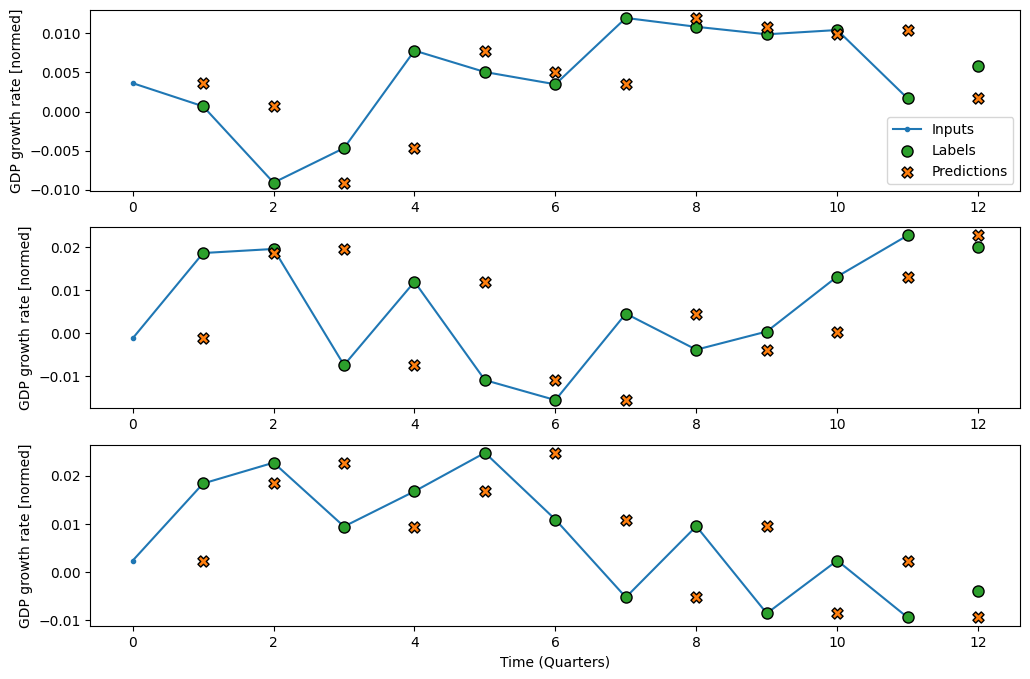

In [38]:
# visualize the baseline prediction

wide_window = WindowGenerator(
    input_width=12, label_width=12, shift=1,
    label_columns=['GDP growth rate'])

wide_window

wide_window.plot(baseline)

# LSTM architecture and model fitting

In [39]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam


input_shape = (sequence_length, X_train.shape[2]) # sequence length and number of features

# Create a sequential model
model = Sequential()

model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics = ['mse'])

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                19200     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 19265 (75.25 KB)
Trainable params: 19265 (75.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
model.fit(X_train,y_train, batch_size = 25, epochs = 20, validation_data = (X_val, y_val))

Epoch 1/20
7/7 [==============================] - 7s 212ms/step - loss: 2.3431e-04 - mse: 2.3431e-04 - val_loss: 8.3269e-04 - val_mse: 8.3269e-04
Epoch 2/20
7/7 [==============================] - 0s 16ms/step - loss: 1.2836e-04 - mse: 1.2836e-04 - val_loss: 7.2408e-04 - val_mse: 7.2407e-04
Epoch 3/20
7/7 [==============================] - 0s 27ms/step - loss: 1.0443e-04 - mse: 1.0443e-04 - val_loss: 8.3211e-04 - val_mse: 8.3211e-04
Epoch 4/20
7/7 [==============================] - 0s 15ms/step - loss: 8.1393e-05 - mse: 8.1393e-05 - val_loss: 7.6822e-04 - val_mse: 7.6822e-04
Epoch 5/20
7/7 [==============================] - 0s 14ms/step - loss: 7.8532e-05 - mse: 7.8532e-05 - val_loss: 7.6868e-04 - val_mse: 7.6868e-04
Epoch 6/20
7/7 [==============================] - 0s 32ms/step - loss: 7.2169e-05 - mse: 7.2169e-05 - val_loss: 7.3222e-04 - val_mse: 7.3222e-04
Epoch 7/20
7/7 [==============================] - 0s 17ms/step - loss: 6.6351e-05 - mse: 6.6351e-05 - val_loss: 6.4369e-04 - val_

In [41]:
predictions = model.predict(X_test)

2/2 [==============================] - 1s 9ms/step


In [42]:
# evaluate prediction metrics

results = model.evaluate(X_test, y_test)

results

2/2 [==============================] - 0s 18ms/step - loss: 1.4211e-04 - mse: 1.4211e-04


[0.0001421103806933388, 0.0001421103806933388]

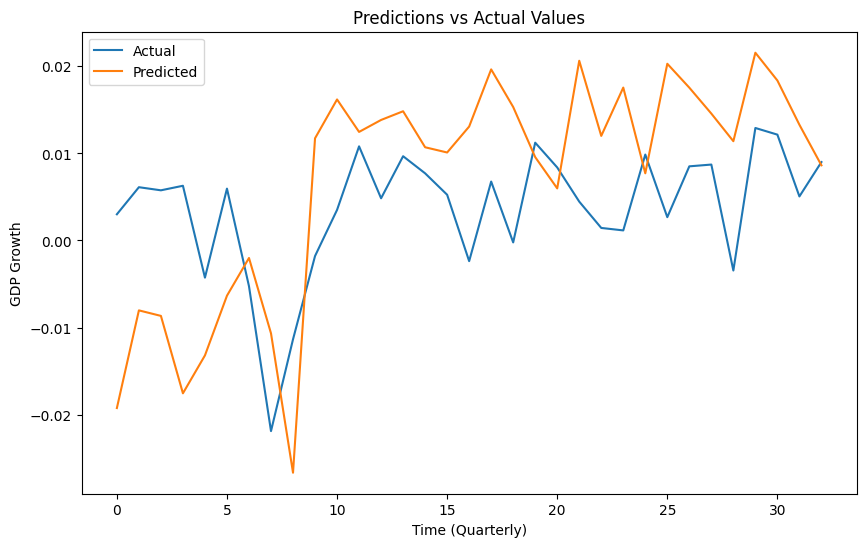

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Time (Quarterly)')
plt.ylabel('GDP Growth')
plt.title('Predictions vs Actual Values')
plt.legend()
plt.show()